# Convertible Bonds Pricing Analytics
------------------
> **Idriss Afra**

This project aims to implement Convertible Bonds pricing and risk analytics.

## Introduction to Convertible Bonds

Convertible bonds are hybrid securities combining debt and equity features. They pay coupons like regular bonds but include an embedded option to convert into shares of the issuing company. This makes them attractive to investors seeking fixed income with potential equity upside. Issuers benefit from lower borrowing costs and delayed equity dilution.

Pricing convertible bonds requires modelling three main risks:
- **Equity risk**: The underlying stock price evolves stochastically.
- **Credit risk**: Default introduces sudden jumps in value; At default, the bond is replaced by a recovery amount.
- **Rate risk**: As fixed-income instruments, convertibles are sensitive to interest rate movements, which affect discounting and the relative attractiveness of conversion.

To capture equity and credit risk, we use a **Jump–Diffusion framework** via the PDE method: diffusion for stock dynamics and a Poisson jump for default. Interest rates are assumed **deterministic**, following the market yield curve, because equity and credit risks generally dominate pricing and stochastic rates add complexity with limited benefit. Rate risk is managed separately in practice.

In the market, pricing and risk management rely on:
- **Broker quotes** for indicative pricing,
- **Credit spreads** implied from **CDS quotes** or calibrated from **Broker quotes** given an input **Equity volatility**,
- **Equity volatility** implied from **Equity option quotes** or calibrated from **Broker quotes** given input **Credit spreads**,
- **Risk sensitivities** (Delta, Gamma, Vega, credit Greeks, and DV01) for hedging,
- **Dynamic hedging** using stocks/options for equity risk, CDS for credit risk, and swaps or futures for rate risk.

---

## Poisson Default Model

We model default using a Poisson process $N_t$ with deterministic time-varying intensity $\lambda(t)$.  
Assume at most one default, so:

$$
N_t =
\begin{cases}
0, & \text{no default by time } t \\
1, & \text{default occurs by time } t
\end{cases}
$$

The default time $\tau$ is the first jump of the process.

### Survival and Default Probabilities

In a Poisson process, the probability of observing $k$ jumps in $[0, t]$ with intensity $\lambda(t)$ is:

$$
\mathbb{P}(N_t = k) = \frac{\Lambda(t)^k}{k!} e^{-\Lambda(t)}, \quad \text{where } \Lambda(t) = \int_0^t \lambda(s)\,ds
$$

- $\lambda(t)$ is the instantaneous forward hazard rate (default intensity): the likelihood of default per unit time at time $t$.  
- $\Lambda(t)$ is the cumulative hazard: the total risk accumulated up to time $t$.  

Since we assume at most one jump:

- **Survival probability** (no default by time $t$):

$$
\mathbb{P}(\tau > t) = \mathbb{P}(N_t = 0) = e^{-\Lambda(t)}
$$

- **Default probability** (default occurs by time $t$):

$$
\mathbb{P}(\tau \le t) = 1 - e^{-\Lambda(t)}
$$

Over a small interval $[t, t + dt)$, the increment $dN_t = N_{t+dt} - N_t$ behaves as:

$$
dN_t =
\begin{cases}
1, & \text{with probability } \lambda(t)\,dt + o(dt) \\
0, & \text{with probability } 1 - \lambda(t)\,dt + o(dt)
\end{cases}
$$

---


## Vanilla Bond Pricing Model

Let:
- Discount factor: $P(t) = e^{-\int_0^t r_u\,du}$, where $r_u$ is the instantaneous forward rate at time $u$.
- $C$: coupon amount, paid at times $t_1, \dots, t_n = T$
- $N$ : par value (Notional)
- $R$: recovery rate  
- $AI(t)$: accrued interest at time $t$

### Pricing Formula

The bond price is the expected present value of all cash flows:

$$
V_0 = \mathbb{E}\left[ \sum_{i=1}^n N \cdot C \cdot P(t_i) \cdot \mathbf{1}_{\{\tau > t_i\}} + N \cdot P(T) \cdot \mathbf{1}_{\{\tau > T\}} + P(\tau) \cdot R \cdot (N + AI(\tau)) \cdot \mathbf{1}_{\{\tau \le T\}} \right]
$$

Where $R \cdot(N + AI(\tau))$ is the recovery amount (claim) in case of default.

Using:
- $\mathbb{E}[\mathbf{1}_{\{\tau > t\}}] = e^{-\Lambda(t)}$
- $\mathbb{E}[f(\tau) \cdot \mathbf{1}_{\{\tau \le T\}}] = \int_0^T f(t) \cdot d\mathbb{P}(\tau \le T)\ = \int_0^T f(t) \cdot \lambda(t) e^{-\Lambda(t)}\,dt$

The full pricing formula turns into the following:

$$
\boxed{V_0 = \sum_{i=1}^n N \cdot C \cdot P(t_i) \cdot e^{-\Lambda(t_i)} + N \cdot P(T) \cdot e^{-\Lambda(T)} + \int_0^T P(t) \cdot R \cdot [N + AI(t)] \cdot \lambda(t) \cdot e^{-\Lambda(t)}\,dt}
$$


In [1]:
import math
import numpy as np

# Fallback: prefer np.trapezoid (recent version), fall back to np.trapz if not present
_trapezoid = getattr(np, "trapezoid", np.trapz)

# Helper to wrap float or callable inputs
def wrap(name, x):
    if callable(x):
        return x
    try:
        val = float(x)
    except Exception as e:
        raise ValueError(f"{name} must be float or callable.") from e
    return lambda t: val

class DeterministicBondPricer:
    """
    Deterministic fixed coupon bond.
    Inputs:
        r : risk-free rate (Instantenous forward rate) -- float or function of t
        default_intensity (λ) : default intensity (Instantenous forward hazard rate) -- float or function of t
        recovery_rate (R) : fractional recovery -- float
        maturity : years -- float
        coupon_rate : annual coupon rate -- float
        coupon_frequency : number of coupon payments per year -- int
        par_value : notional (default: 100.0) -- float
    """
    def __init__(self, r, default_intensity, recovery_rate, maturity, coupon_rate, coupon_frequency, par_value=100.0):
        """
        Initializes determinstic bond pricer.
        """
        # Core numeric validations
        if recovery_rate < 0. or recovery_rate > 1.: raise ValueError("recovery_rate must be in [0,1].")
        if maturity <= 0.: raise ValueError("maturity must be > 0.")
        if coupon_frequency < 0 or not isinstance(coupon_frequency, int): raise ValueError("coupon_frequency must be a non-negative integer.")
        if par_value <= 0.: raise ValueError("par_value must be > 0.")
        # Store attributes
        self.r = wrap("r", r)
        self.lam = wrap("default_intensity", default_intensity)
        self.R = recovery_rate
        self.maturity = maturity
        self.coupon_rate = coupon_rate
        self.coupon_frequency = coupon_frequency
        self.par_value = par_value
        self._build_coupon_schedule()
    
    def _build_coupon_schedule(self):
        """
        Creates array of coupon payment dates up to maturity.
        """
        if self.coupon_frequency == 0:
            self.coupon_dates = []
        else:
            period = 1. / self.coupon_frequency
            coupon_dates = np.arange(period, self.maturity + 1e-8, period)
            self.coupon_dates = [c for c in coupon_dates if c <= self.maturity + 1e-8]
    
    def get_coupon_amount(self):
        """
        Gets coupon payment amount.
        """
        return 0.0 if self.coupon_frequency == 0 else self.coupon_rate * self.par_value / self.coupon_frequency
    
    def get_accrued_interest(self, t):
        """
        Gets accrued interest at time t.
        """
        if t <= 0 or self.coupon_frequency == 0:
            # The pricer gives dirty prices only
            return 0.0
        past = [c for c in self.coupon_dates if c <= t]
        if len(past) == 0:
            last_coupon = 0.0
            future = self.coupon_dates[0]
        else:
            last_coupon = past[-1]
            future_list = [c for c in self.coupon_dates if c > t]
            if not future_list:
                return 0.0
            future = future_list[0]
        period = future - last_coupon
        if period <= 0:
            return 0.0
        accrual = (t - last_coupon) / period
        return self.get_coupon_amount() * accrual
    
    def _risky_discount_factor(self, t, dt=1e-3):
        """
        Computes risky discount factor to time t (Trapezoidal rule) : PS(t) * P(t) = exp(-∫0^t (r(s) + λ(s)) ds).
        """
        if t <= 0:
            return 1.0
        n = max(2, int(math.ceil(t / dt)))
        grid_t = np.linspace(0.0, t, n + 1)
        r_t = np.array([self.r(x) for x in grid_t])
        lam_t = np.array([self.lam(x) for x in grid_t])
        if np.any(lam_t < 0):
            neg_idx = np.where(lam_t < 0)[0][0]
            raise ValueError(f"default_intensity must be >=0 (t={grid_t[neg_idx]:.6f}, λ={lam_t[neg_idx]:.6f})")
        integ = _trapezoid(r_t + lam_t, grid_t)
        return math.exp(-integ)

    def price(self, dt=1e-3):
        """
        Prices the vanilla bond.
        Returns a dictionary with total value, coupon PV, principal PV, and recovery value.
        """
        # Coupon and principal PVs
        coup = self.get_coupon_amount()
        coupon_pv = sum(coup * self._risky_discount_factor(coup_date, dt) for coup_date in self.coupon_dates)
        principal_pv = self.par_value * self._risky_discount_factor(self.maturity, dt)
        # Recovery leg: ∫0^T λ(t) R (Par + AI(t)) e^{-∫0^t (r+λ)} dt (Trapezoidal rule)
        recovery_pv = 0.0
        n = max(2, int(math.ceil(self.maturity / dt)))
        grid_t = np.linspace(0.0, self.maturity, n + 1)
        if len(grid_t) >= 2:
            lam_t = np.array([self.lam(ti) for ti in grid_t])
            if np.any(lam_t < 0):
                neg_idx = np.where(lam_t < 0)[0][0]
                raise ValueError(f"default_intensity must be >=0 (t={grid_t[neg_idx]:.6f}, λ={lam_t[neg_idx]:.6f})")
            risky_df_t = np.array([self._risky_discount_factor(ti) for ti in grid_t])
            claim_t = self.par_value + np.array([self.get_accrued_interest(ti) for ti in grid_t])
            integrand_t = lam_t * self.R * claim_t * risky_df_t
            recovery_pv = _trapezoid(integrand_t, grid_t)
        # Total dirty price
        total = coupon_pv + principal_pv + recovery_pv
        return {
            'total_value': total,
            'coupon_pv': coupon_pv,
            'principal_pv': principal_pv,
            'recovery_value': recovery_pv
        }

---

## Convertible Bond Pricing Model

### Model and Objective

We work on a filtered risk-neutral probability space $(\Omega, \mathcal{F}, (\mathcal{F}_t)_{t \ge 0}, \mathbb{Q})$ supporting:
- Brownian motion $W_t$,
- Poisson process $N_t$ with intensity $\lambda_t$.

The stock price $S_t$ follows:

$$
dS_t = \mu_t S_t\, dt + \sigma_t S_t\, dW_t - \eta S_{t-}\, dN_t
$$

where $\eta \in (0,1)$ is the proportional drop at default.

A convertible bond has pre-default value $V(t,S)$. At default, the contract is killed and replaced by a recovery amount $A(t)$ such as:

$$
\text{Claim}(t) = \text{N} + AI(t), \qquad A(t) = R \cdot \text{Claim}(t)
$$

where:
- $AI(t)$ is accrued interest at time $t$,
- $R \in [0,1]$ is the recovery rate applied to the claim.

### Itô’s Lemma with Jumps

For $V \in C^{1,2}$:

$$
\begin{aligned}
dV(t,S_t) &= V_t\, dt + V_S\, dS_t + \tfrac{1}{2} V_{SS}\, \sigma_t^2 S_t^2\, dt \\
&\quad + \big( V(t,S_{t-}+\Delta S_t) - V(t,S_{t-}) - V_S \Delta S_t \big)\, dN_t
\end{aligned}
$$

where $\Delta S_t = -\eta S_{t-}$.

At default:
$
V(t,S_{t-}+\Delta S_t) = A(t) = R \cdot \text{Claim}(t)
$

Causing a jump in $V$ of:
$
(A(t) - V(t,S_{t-}))\, dN_t
$

Thus:
$$
dV = \big( V_t + \mu_t S_t V_S + \tfrac{1}{2}\sigma_t^2 S_t^2 V_{SS} \big)\, dt
+ \sigma_t S_t V_S\, dW_t + (A(t) - V)\, dN_t
$$


### Risk-Neutral Drift of $S$

Under $\mathbb{Q}$, the **dividend-adjusted discounted stock** must be a martingale:

$$
D_t = e^{-\int_0^t q_u\, du} S_t / e^{\int_0^t r_u\, du}
$$

Write $dN_t = d\widetilde{N}_t + \lambda_t\, dt$ (Doob–Meyer decomposition). Then:
$$
dS_t = (\mu_t - \eta \lambda_t) S_t\, dt + \sigma_t S_t\, dW_t - \eta S_{t-}\, d\widetilde{N}_t
$$

Martingale condition:
$$
\mu_t - (r_t - q_t) - \eta \lambda_t = 0 \quad \Rightarrow \quad
\boxed{\mu_t = r_t - q_t + \eta \lambda_t}
$$


### Expected Change of $V$

Plugging drift:
$$
\mathbb{E}^\mathbb{Q}[dV | \mathcal{F}_t] =
\big( V_t + (r_t - q_t + \eta \lambda_t) S_t V_S + \tfrac{1}{2}\sigma_t^2 S_t^2 V_{SS} \big)\, dt
+ \lambda_t (A(t) - V)\, dt
$$


### No-Arbitrage Condition

Discounted bond value is a martingale:
$$
\mathbb{E}^\mathbb{Q}[dV] = r_t V\, dt
$$

So:
$$
V_t + (r_t - q_t + \eta \lambda_t) S V_S + \tfrac{1}{2}\sigma_t^2 S^2 V_{SS} + \lambda_t(A - V) = r_t V
$$

Rearrange:
$$
V_t + \tfrac{1}{2}\sigma_t^2 S^2 V_{SS} + (r_t - q_t + \eta \lambda_t) S V_S - (r_t + \lambda_t) V + \lambda_t A(t) = 0
$$

Finally, substitute $A(t) = R \cdot \text{Claim}(t)$:
$$
\boxed{
V_t + \tfrac{1}{2}\sigma_t^2 S^2 V_{SS} + (r_t - q_t + \eta \lambda_t) S V_S - (r_t + \lambda_t) V + \lambda_t R \text{Claim}(t) = 0
}
$$

### Boundary Conditions at Event Dates

#### 1. Coupon Payment
Similar  to regular bonds, convertibles pay coupons to the investor:
$$
\text{For } t \in \text{coupon dates:} \quad V_t \leftarrow V_t + \text{C}
$$
#### 2. Conversion Condition
At conversion dates, the holder can exchange the bond for shares:
$$
\text{For } t \in \text{conversion dates:} \quad V_t \leftarrow \max(V_t, \text{CR} \cdot S_t)
$$
where the conversion ratio (CR) is defined as:
$$
\text{CR} = \frac{\text{N}}{\text{Conversion Price}}
$$

**Conversion Price in Practice**:  
- The conversion price is set at issuance and represents the price per share for conversion.  
- It is typically **20–30% above the stock price at issuance**, ensuring conversion only occurs if the stock appreciates significantly.

#### 3. Soft Call Feature
Convertibles may be callable at specified dates. If the stock is above a trigger $L$, the issuer can redeem (call) for cash at a call price $C(t)$ often at or near par plus accrued, so the practical effect is to induce conversion when the equity value is high.

In the PDE we enforce this by capping the continuation value at the call price while preserving the conversion alternative:
$$
\text{For } t \in \text{call dates:} \quad V_t \leftarrow \max(\text{CR} \cdot S_t \min(V_t, \text{C(t)})) \quad \text{if } S_t \ge L
$$

In many issues the trigger is based on an observation rule on at least 20 of the last 30 trading days; For simplicity we model it as a single-date condition.

### PDE Pricing Method
We use a Crank–Nicolson implicit finite-difference scheme, as detailed in the following project: [Hull & White One Factor Model](https://github.com/Idriss-Afra/Hull-White-One-Factor-Model/blob/main/Hull-White%201F%20Model.ipynb).

In [ ]:
from scipy.linalg import solve_banded
from scipy.interpolate import PchipInterpolator

class ConvertibleBondPricer:
    """
    Convertible Bond PDE Pricer.
    PDE:
        ∂V/∂t + 0.5 * σ² * S² * V_SS + (r - q + η * λ) * S * V_S - (r + λ) * V + λ * R * Claim = 0
    where Claim = Par + Accrued Coupon.
    Inputs:
    S0 : current underlying price -- float
    r  : risk-free rate (instantaneous forward rate) -- float or function of t
    q  : continuous dividend yield (instantaneous forward dividend rate) -- float or function of t
    sigma : volatility -- float
    default_intensity (λ) : default intensity (instantaneous forward hazard rate) -- float or function of t
    recovery_rate (R) : fractional recovery applied to Claim in default -- float
    maturity : maturity in years -- float
    coupon_rate : annual coupon rate -- float
    coupon_frequency : number of coupon payments per year -- int
    par_value : bond notional (default 100.0) -- float
    conversion_dates : conversion exercise dates -- array or None
    conversion_ratio (CR) : shares received if converted (default 0.0 if None) -- float or None
    call_dates : allowed call dates -- array or None
    call_price : call price if called (default par_value + ai(t) if None) -- float or None
    call_trigger : stock level L triggering the call -- float or None
    eta : propotional drop at default (default 1) -- float
    nx : number of stock grid nodes (odd, default 201) -- int
    nstdev : number of standard deviation (default 5) -- float
    dt : target maximum time step size (default 1e-3) -- float
    """
    
    def __init__(self, S0, r, q, sigma, default_intensity, recovery_rate, maturity, coupon_rate, coupon_frequency, 
                 par_value=100.0, conversion_dates=None, conversion_ratio=None, call_dates=None, 
                 call_price=None, call_trigger=None, eta=1, nx=201, nstdev=5, dt=1e-3):
        """
        Initializes Convertible Bond Pricer.
        """
        # Core numeric validations
        if S0 <= 0: raise ValueError("S0 must be > 0.")
        if sigma <= 0: raise ValueError("sigma must be > 0.")
        if not (0.0 <= recovery_rate <= 1.0): raise ValueError("recovery_rate must be in [0,1].")
        if maturity <= 0: raise ValueError("maturity must be > 0.")
        if coupon_frequency < 0 or int(coupon_frequency) != coupon_frequency: raise ValueError("coupon_frequency must be a non-negative integer.")
        if par_value <= 0: raise ValueError("par_value must be > 0.")
        if eta < 0: raise ValueError("eta must be >= 0.")
        if nx < 51: raise ValueError("nx must be >= 51.")
        if nstdev <= 0: raise ValueError("nstdev must be > 0.")
        if dt <= 0: raise ValueError("dt must be > 0.")
        # Store attributes
        self.S0 = S0
        self.r = wrap("r", r)
        self.q = wrap("q", q)
        self.lam = wrap("default_intensity", default_intensity)
        self.sigma = sigma
        self.R = recovery_rate
        self.maturity = maturity
        self.coupon_rate = coupon_rate
        self.coupon_frequency = coupon_frequency
        self.par_value = par_value
        self.eta = eta
        self.nx = nx
        self.nstdev = nstdev
        self.dt = dt
        # Ensure odd grid size so S0 is a node
        if self.nx % 2 == 0:
            self.nx += 1
        # Coupon schedule
        self._generate_coupon_schedule()
        # Discrete conversion schedule
        self.set_conversion_dates(conversion_dates, conversion_ratio, False)
        # Discrete call schedule
        self.set_call_dates(call_dates, call_trigger, call_price, False)
        # PDE time x space grid
        self._setup_grid()

    def _generate_coupon_schedule(self):
        """
        Creates array of coupon payment dates up to maturity.
        """
        if self.coupon_frequency == 0:
            self.coupon_dates = np.array([])
        else:
            period = 1.0 / self.coupon_frequency
            self.coupon_dates = np.arange(period, self.maturity + 1e-8, period)
            self.coupon_dates = self.coupon_dates[self.coupon_dates <= self.maturity]

    def set_conversion_dates(self, conversion_dates, conversion_ratio, update_grid=True):
        """
        Sets or updates conversion dates and ratio.
        """
        if conversion_dates is None:
            self.conversion_dates = np.array([])
            self.cr = 0. # effectively no conversion
        else:
            self.conversion_dates = np.array(conversion_dates)
            self.conversion_dates = self.conversion_dates[(self.conversion_dates > 0) & (self.conversion_dates <= self.maturity)]
            self.conversion_dates = np.unique(self.conversion_dates)
            if len(self.conversion_dates) == 0: 
                self.cr = 0. # effectively no conversion
                print("Warning: conversion_dates is empty after filtering; Setting conversion_ratio to 0 (no conversion).")
            else:
                self.cr = conversion_ratio # number of shares received if converted
                if self.cr is None: raise ValueError("conversion_ratio must be provided if conversion_dates are specified.")
                if self.cr <= 0.: raise ValueError("conversion_ratio must be > 0.")
        if update_grid: self._setup_grid()
    
    def set_call_dates(self, call_dates, call_trigger, call_price=None, update_grid=True):
        """
        Sets or updates call dates, trigger and price.
        """
        if call_price is not None and call_price <= 0: raise ValueError("call_price must be > 0 if provided.")
        self.call_price = wrap("call_price", call_price) if call_price is not None else (lambda t : self.par_value + self.get_accrued_interest(t))
        if call_dates is None:
            self.call_dates = np.array([])
            self.call_trigger = None  # effectively no call
        else:
            self.call_dates = np.array(call_dates)
            self.call_dates = self.call_dates[(self.call_dates > 0) & (self.call_dates <= self.maturity)]
            self.call_dates = np.unique(self.call_dates)
            if len(self.call_dates) == 0: 
                self.call_trigger = None  # effectively no call
                print("Warning: call_dates is empty after filtering; Setting call_trigger to None (no call).")
            else:
                self.call_trigger = call_trigger  # stock level L triggering the call
                if call_trigger is None: raise ValueError("call_trigger must be provided if call_dates are specified.")
                if self.call_trigger <= 0.: raise ValueError("call_trigger must be > 0.")
        if update_grid: self._setup_grid()
            
    def _setup_grid(self):
        """
        Assembles time grid and symmetric linear stock grid centered at S0.
        """
        # Time grid
        event_times = np.concatenate([[0.0], self.coupon_dates, self.conversion_dates, self.call_dates, [self.maturity]])
        event_times = np.unique(event_times)
        time_grid = []
        for i in range(len(event_times) - 1):
            t_start, t_end = event_times[i], event_times[i + 1]
            n_steps = max(1, int(np.ceil((t_end - t_start) / self.dt)))
            segment = np.linspace(t_start, t_end, n_steps + 1)
            if i == 0:
                time_grid.extend(segment)
            else:
                time_grid.extend(segment[1:])
        self.t = np.array(time_grid)
        # Stock grid
        S_min = self.S0 * np.exp(-self.nstdev * self.sigma * np.sqrt(self.maturity))
        S_max = self.S0 * np.exp(self.nstdev * self.sigma * np.sqrt(self.maturity))
        d_down = self.S0 - S_min
        d_up = S_max - self.S0
        W = min(d_down, d_up)
        self.S = np.linspace(self.S0 - W, self.S0 + W, self.nx) # Centered at S0
        self.dS = self.S[1] - self.S[0]
        
    def _is_coupon_date(self, t, tol=1e-8):
        """
        Returns True if t coincides with a scheduled coupon date within tolerance.
        """
        return any(abs(t - cd) < tol for cd in self.coupon_dates)
    
    def _is_call_date(self, t, tol=1e-8):
        """
        Returns True if t matches an allowed call date within tolerance.
        """
        return any(abs(t - cd) < tol for cd in self.call_dates)

    def _is_conversion_date(self, t, tol=1e-8):
        """
        Returns True if t matches an allowed conversion date within tolerance.
        """
        return any(abs(t - cd) < tol for cd in self.conversion_dates)

    def get_coupon_amount(self):
        """
        Gets coupon payment amount.
        """
        return 0.0 if self.coupon_frequency == 0 else self.coupon_rate * self.par_value / self.coupon_frequency
        
    def get_accrued_interest(self, t):
        """
        Gets accrued interest at time t.
        """
        if t <= 0 or len(self.coupon_dates) == 0:
            # The pricer gives dirty prices only
            return 0.0
        past = self.coupon_dates[self.coupon_dates <= t]
        if len(past) == 0:
            last_coupon = 0.0
            future = self.coupon_dates[0]
        else:
            last_coupon = past[-1]
            future_dates = self.coupon_dates[self.coupon_dates > t]
            if len(future_dates) == 0:
                return 0.0
            future = future_dates[0]
        period = future - last_coupon
        if period <= 0:
            return 0.0
        accrual = (t - last_coupon) / period
        return self.get_coupon_amount() * accrual

    def _terminal_condition(self):
        """
        Returns payoff at maturity.
        """
        t_curr = self.maturity
        # Final redemption value (par_value)
        redemption = self.par_value
        V = np.full_like(self.S, redemption)
        # Coupon payment condition
        if self._is_coupon_date(t_curr):
            V += self.get_coupon_amount()
        # Conversion option exercise condition
        if self._is_conversion_date(t_curr):
            exercise_value = self.cr * self.S
            exercise_cond = exercise_value >= redemption
            V = np.maximum(V, exercise_value)
            self.fraction_of_nodes_exercised.append({'time': float(t_curr), 'fraction_of_nodes_exercised': float(exercise_cond.mean())})
        # Call option exercise condition
        if self._is_call_date(t_curr):
            call_value = self.call_price(t_curr)
            if call_value <= 0: raise ValueError("call_price must be > 0: value given at t={:.4f} is {:.4f}.".format(t_curr, call_value))
            call_cond = self.S >= self.call_trigger
            if self._is_conversion_date(t_curr):
                V = np.where(call_cond, np.maximum(self.cr * self.S, np.minimum(V, call_value)), V)
            else:
                V = np.where(call_cond, np.minimum(V, call_value), V)
        return V
        
    def _pde_step(self, V_next, dt_step, t_curr, theta=0.5):
        """
        Performs one Crank–Nicolson backward-step (default: theta=0.5).
        Inputs:
            V_next : value at next time layer (t + dt)
            dt_step : time increment
            t_curr : current backward time node
        Returns:
            np.ndarray new value vector at current_time t_curr.
        """
        # Coefficients
        nx = self.nx
        dx = self.dS
        r_t = float(self.r(t_curr))
        q_t = float(self.q(t_curr))
        lambda_t = float(self.lam(t_curr))
        if lambda_t < 0: raise ValueError("default_intensity must be >= 0: value given at t={:.4f} is {:.4f}.".format(t_curr, lambda_t))
        claim_t = self.par_value + self.get_accrued_interest(t_curr)
        var = self.sigma**2 * self.S**2 * dt_step
        mu = (r_t - q_t + self.eta * lambda_t) * self.S * dt_step
        rdt = (r_t + lambda_t) * dt_step
        # Source term from recovery in default
        t_next = t_curr + dt_step
        lambda_tdt = float(self.lam(t_next))
        if lambda_tdt < 0: raise ValueError("default_intensity must be >= 0: value given at t={:.4f} is {:.4f}.".format(t_next, lambda_tdt))
        claim_tdt = self.par_value + self.get_accrued_interest(t_next)
        source = dt_step * (theta * lambda_t * self.R * claim_t + (1 - theta) * lambda_tdt * self.R * claim_tdt)
        # Tridiagonal coefficients 
        alpha_u = (var + mu * dx) / (2.0 * dx**2)
        alpha_d = (var - mu * dx) / (2.0 * dx**2)
        alpha_c = np.full(nx, - var / dx**2)
        # Right-hand side
        p_ur = (1 - theta) * alpha_u
        p_dr = (1 - theta) * alpha_d
        p_cr = (1 - theta) * alpha_c + 1 - (1 - theta) * rdt
        p_ul = -theta * alpha_u
        p_dl = -theta * alpha_d
        p_cl = -theta * alpha_c + 1 + theta * rdt
        right = np.empty(nx)
        right[1:nx-1] = (p_dr[1:nx-1] * V_next[0:nx-2] +
                         p_cr[1:nx-1] * V_next[1:nx-1] +
                         p_ur[1:nx-1] * V_next[2:nx] + source)
        # Boundary conditions
        # Left stock grid boundary: Price is insensitive to Equity (dV/dS = 0)
        p_cl[0] = 1.0; p_ul[0] = -1.0; p_dl[0] = 0.0
        right[0] = 0.0
        # Right stock grid boundary:
        p_cl[-1] = 1.0; p_dl[-1] = -1.0; p_ul[-1] = 0.0
        future_event_dates = np.array([])
        if self.conversion_dates.size and np.any(self.conversion_dates >= t_curr - 1e-8):
            future_event_dates = self.conversion_dates[self.conversion_dates >= t_curr - 1e-8]
        if self.call_dates.size and np.any(self.call_dates >= t_curr - 1e-8):
            future_call_dates = self.call_dates[self.call_dates >= t_curr - 1e-8]
            future_event_dates = np.concatenate([future_event_dates, future_call_dates])
        if future_event_dates.size:
            # Price is approximated by the PV of the conversion payoff at the next event date
            t_next = future_event_dates.min()
            t_grid_to_next_event = self.t[(self.t >= t_curr - 1e-8) & (self.t <= t_next + 1e-8)]
            q_grid_to_next_event = np.array([self.q(u) for u in t_grid_to_next_event])
            lambda_grid_to_next_event = np.array([self.lam(u) for u in t_grid_to_next_event])
            df_eq = math.exp(-_trapezoid(q_grid_to_next_event + (1 - self.eta) * lambda_grid_to_next_event, t_grid_to_next_event))
            slope = self.cr * df_eq
        else:
            # If no future conversion or call event, Price becomes insensitive to Equity (dV/dS = 0)
            slope = 0.0
        right[-1] = slope * dx
        # Solver
        upper_band = np.insert(p_ul, 0, 0.0)[:-1]
        lower_band = np.append(p_dl[1:nx], 0.0)
        bands = np.array([upper_band, p_cl, lower_band])
        # Current V
        V_curr = solve_banded((1, 1), bands, right)
        return V_curr
        
    def price(self, store_price_grid=False):
        """
        Solves the PDE.
        Inputs:
            store_price_grid : store the price grid at t=0 across the stock grid
        Returns:
            float dirty price at S0
        """
        self.fraction_of_nodes_exercised = []
        # Terminal condition
        V = self._terminal_condition()
        # Backward time-stepping
        for i in range(len(self.t) - 2, -1, -1):
            dt_step = self.t[i+1] - self.t[i]
            t_curr = self.t[i]
            # One PDE backward step : Crank–Nicolson
            V = self._pde_step(V, dt_step, t_curr)
            # Coupon payment condition
            if self._is_coupon_date(t_curr):
                V += self.get_coupon_amount()
            # Conversion option exercise condition
            if self._is_conversion_date(t_curr):
                exercise_value = self.cr * self.S
                exercise_cond = exercise_value >= V
                V = np.maximum(V, exercise_value)
                self.fraction_of_nodes_exercised.append({'time': float(t_curr), 'fraction_of_nodes_exercised': float(exercise_cond.mean())})
            # Call option exercise condition
            if self._is_call_date(t_curr):
                call_value = self.call_price(t_curr)
                if call_value <= 0: raise ValueError("call_price must be > 0: value given at t={:.4f} is {:.4f}.".format(t_curr, call_value))
                call_cond = self.S >= self.call_trigger
                if self._is_conversion_date(t_curr):
                    V = np.where(call_cond, np.maximum(self.cr * self.S, np.minimum(V, call_value)), V)
                else:
                    V = np.where(call_cond, np.minimum(V, call_value), V)
        if store_price_grid:
            self._price_grid_at_t0 = V.copy()
        mid_index = (self.nx - 1)//2
        return float(V[mid_index])
    
    def get_fraction_of_nodes_exercised(self):
        """
        Returns list of {'time': t, 'fraction': fraction_of_nodes_exercised} for last price run.
        """
        if not self.fraction_of_nodes_exercised:
            _ = self.price()
        return list(reversed(self.fraction_of_nodes_exercised))

    def get_pricing_details(self):
        """
        Returns dictionary with price and fractions of exercised nodes per exercise date.
        """
        return {'price': self.price(), 'fraction_of_nodes_exercised': self.get_fraction_of_nodes_exercised()}

    def get_risk_sensitivities(self, spot_shift_pct=0.005, vol_shift_abs=0.005):
        """
        Computes price, Delta, Gamma and Vega.
        Inputs:
            spot_shift_pct : relative spot bump (e.g. 0.005 = 0.5%)
            vol_shift_abs  : absolute vol bump (e.g. 0.005 = 0.5%)
        Returns dict: {'price','delta','gamma','vega','spot_shift','vol_shift'}
        """
        # Save original state
        orig_S0, orig_sigma, orig_S, orig_t, orig_dS = self.S0, self.sigma, self.S.copy(), self.t.copy(), self.dS
        # Baseline
        price = self.price()
        # Spot bump central difference (rebuild grid each time because S0 changes)
        dS_abs = orig_S0 * spot_shift_pct
        self.S0 = orig_S0 + dS_abs
        self._setup_grid()
        price_s_up = self.price()
        self.S0 = orig_S0 - dS_abs
        self._setup_grid()
        price_s_dn = self.price()
        # Restore original grid before vol bumps
        self.S0, self.S, self.t, self.dS = orig_S0, orig_S, orig_t, orig_dS
        # Vol bump central difference (rebuild grid each time because sigma changes bounds)
        self.sigma = orig_sigma + vol_shift_abs
        self._setup_grid()
        price_v_up = self.price()
        self.sigma = max(orig_sigma - vol_shift_abs, 0.0001)  # avoid zero vol
        self._setup_grid()
        price_v_dn = self.price()
        # Restore original parameters & grid
        self.sigma, self.S0, self.S, self.t, self.dS = orig_sigma, orig_S0, orig_S, orig_t, orig_dS
        # Greeks
        delta = (price_s_up - price_s_dn) / (2 * dS_abs)
        gamma = (price_s_up + price_s_dn - 2 * price) / (dS_abs ** 2)
        vega = (price_v_up - price_v_dn) / (2 * vol_shift_abs)
        return {
            'price': price,
            'delta': delta,
            'gamma': gamma,
            'vega': vega,
            'spot_shift': dS_abs,
            'vol_shift': vol_shift_abs
        }
    
    def get_risk_sensitivities_profile(self, stock_range=None, n_points=21,
                                       spot_shift_pct=0.005, vol_shift_abs=0.005):
        """
        Computes numerical profiles for Price, Delta, Gamma, Vega across a stock range.
        Inputs:
            stock_range : (S_min, S_max) or None -> auto (0.5*S0, 2*S0)
            n_points : number of output evaluation points (default 21)
            spot_shift_pct : relative bump used for delta/gamma finite differences
            vol_shift_abs : absolute volatility bump for vega
        Returns dict with numpy arrays:
            {
              'S': stock prices,
              'price': price profile,
              'delta': delta profile,
              'gamma': gamma profile,
              'vega': vega profile,
              'spot_shift_abs': used spot shift,
              'vol_shift_abs': used vol shift
            }
        """
        # Define target evaluation range
        if stock_range is None:
            stock_range = (max(0.01, 0.5 * self.S0), 2.0 * self.S0)
        S_lo, S_hi = stock_range
        targets = np.linspace(S_lo, S_hi, n_points)
        # Save original state
        orig_S0, orig_S, orig_nx, orig_dS, orig_sigma = self.S0, self.S, self.nx, self.dS, self.sigma
        # Extended uniform stock grid construction
        ext_min = max(0.01, 0.5 * S_lo)
        ext_max = 2.0 * S_hi
        S_mid = 0.5 * (ext_min + ext_max)
        dS_uniform = spot_shift_pct * S_mid
        n_steps = int(np.floor((ext_max - ext_min) / dS_uniform)) + 1
        if n_steps % 2 == 0: n_steps += 1
        S_grid = ext_min + dS_uniform * np.arange(n_steps)
        self.S0 = S_grid[n_steps // 2]
        self.S = S_grid
        self.nx = len(S_grid)
        self.dS = self.S[1] - self.S[0]
        # Baseline price surface
        _ = self.price(store_price_grid=True)
        V_grid = self._price_grid_at_t0.copy()
        price_interp = PchipInterpolator(S_grid, V_grid)
        # Delta & Gamma profiles
        h = self.dS
        delta_grid = np.empty_like(V_grid)
        gamma_grid = np.empty_like(V_grid)
        delta_grid[1:-1] = (V_grid[2:] - V_grid[:-2]) / (2 * h)
        gamma_grid[1:-1] = (V_grid[2:] - 2 * V_grid[1:-1] + V_grid[:-2]) / (h ** 2)
        # Boundary conditions
        delta_grid[0]  = (V_grid[1] - V_grid[0]) / h
        delta_grid[-1] = (V_grid[-1] - V_grid[-2]) / h
        gamma_grid[0] = (delta_grid[1] - delta_grid[0]) / h
        gamma_grid[-1] = (delta_grid[-1] - delta_grid[-2]) / h
        # Interpolators
        delta_interp = PchipInterpolator(S_grid, delta_grid)
        gamma_interp = PchipInterpolator(S_grid, gamma_grid)
        # Vega profile
        self.sigma = orig_sigma + vol_shift_abs
        _ = self.price(store_price_grid=True)
        V_vol_up = self._price_grid_at_t0.copy()
        self.sigma = max(orig_sigma - vol_shift_abs, 0.0001)  # avoid zero vol
        _ = self.price(store_price_grid=True)
        V_vol_dn = self._price_grid_at_t0.copy()
        V_vol_up_interp = PchipInterpolator(S_grid, V_vol_up)
        V_vol_dn_interp = PchipInterpolator(S_grid, V_vol_dn)
        vegas = (V_vol_up_interp(targets) - V_vol_dn_interp(targets)) / (2 * vol_shift_abs)
        # Restore original state
        self.S0, self.S, self.nx, self.dS, self.sigma = orig_S0, orig_S, orig_nx, orig_dS, orig_sigma
        return {
            'S': targets,
            'price': price_interp(targets),
            'delta': delta_interp(targets),
            'gamma': gamma_interp(targets), 
            'vega': vegas,
            'spot_shift_abs': h,
            'vol_shift_abs': vol_shift_abs
        }

    def print_bond_details(self):
        """
        Prints formatted specification summary of the instrument and model inputs.
        """
        print("Convertible Bond:")
        print(f" Par: {self.par_value}")
        print(f" Maturity: {self.maturity:.2f}y")
        print(f" Coupon Rate: {self.coupon_rate*100:.2f}% ({self.coupon_frequency}x)")
        print(f" S0: {self.S0:.2f}")
        print(f" Sigma: {self.sigma:.2%}")
        print(f" Recovery R: {self.R:.2%}")
        if len(self.conversion_dates) == 0:
            print(" Conversion: None")
        else:
            print(f" Conversion Dates: {[round(float(conversion_date), 4) for conversion_date in self.conversion_dates]}")
            print(f" Conversion Ratio: {self.cr}")
            print(f" Conversion Price at issue: {self.par_value / self.cr:.2f}")
        if len(self.call_dates) == 0:
            print(" Call: None")
        else:
            print(f" Call Dates: {[round(float(call_date), 4) for call_date in self.call_dates]}")
            print(f" Call Trigger: {self.call_trigger}")
            print(f" Call Price: {self.call_price(0.0)}")

---

## Numerical Application

1- Test PDE on vanilla bond (conversion disabled):

Deterministic Pricer = 849.578602 | PDE Pricer (no conv) = 849.578602 | Abs Diff = 0.000000

2- Standard Convertible vs Callable Convertible:

Standard convertible (no call):
-------------------------------
Convertible Bond:
 Par: 1000.0
 Maturity: 5.00y
 Coupon Rate: 1.80% (2x)
 S0: 260.00
 Sigma: 20.00%
 Recovery R: 40.00%
 Conversion Dates: [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0]
 Conversion Ratio: 3
 Conversion Price at issue: 333.33
 Call: None

Callable convertible:
---------------------
Convertible Bond:
 Par: 1000.0
 Maturity: 5.00y
 Coupon Rate: 1.80% (2x)
 S0: 260.00
 Sigma: 20.00%
 Recovery R: 40.00%
 Conversion Dates: [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0]
 Conversion Ratio: 3
 Conversion Price at issue: 333.33
 Call Dates: [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5,

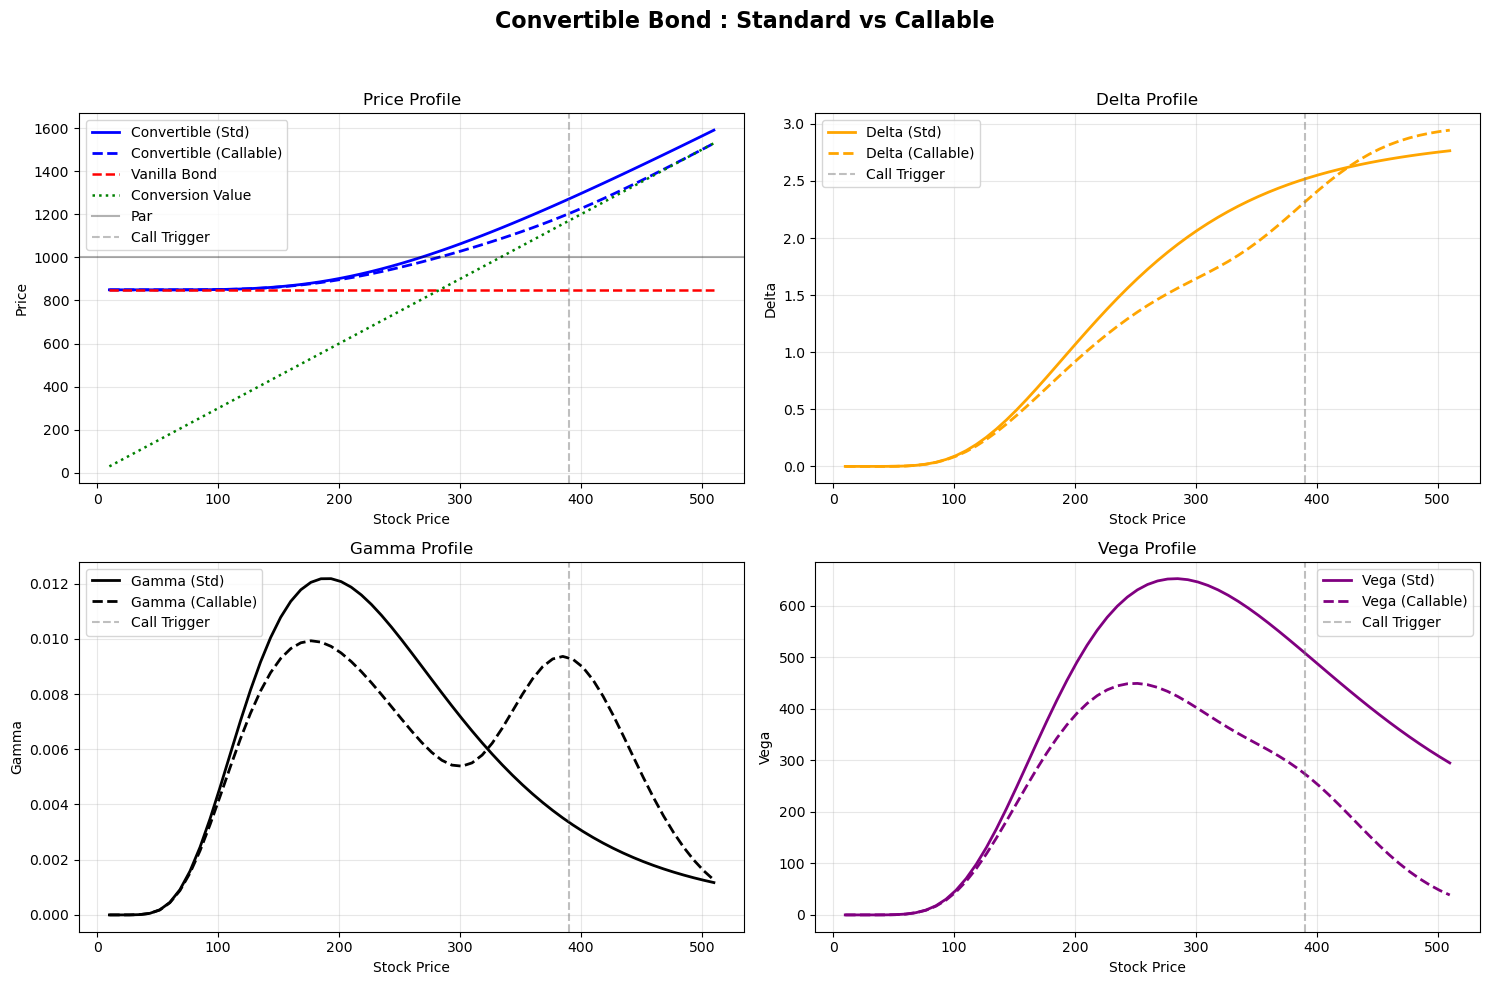

In [3]:
# Parameters for profiles
n_points = 61
stock_range = (10., 510.)
spot_shift_pct = 0.005
vol_shift_abs = 0.005
# Convertible bond parameters
par_value = 1000.0
S0 = 0.5 * (stock_range[0] + stock_range[1])
pde_pricer = ConvertibleBondPricer(
    S0=S0, r=0.035, q=0.01, sigma=0.2, default_intensity=0.03,
    recovery_rate=0.40, conversion_ratio=int(par_value / (1.25 * S0)), # approx conversion price 125% of spot
    maturity=5, coupon_rate=0.018, coupon_frequency=2, par_value=par_value,
    conversion_dates=np.arange(0.5, 5.0 + 0.25, 0.25) # quarterly conversion from 6m to maturity 5y
)
# Vanilla bond parameters
vanilla_pricer = DeterministicBondPricer(
    r=0.035, default_intensity=0.03, recovery_rate=0.40,
    maturity=5.0, coupon_rate=0.018, coupon_frequency=2, par_value=par_value
)
vanilla_bond_price = vanilla_pricer.price()['total_value']

# 1 - Vanilla bond check (no conversion)
print("1- Test PDE on vanilla bond (conversion disabled):\n")
orig_conv_dates, orig_cr = pde_pricer.conversion_dates.copy(), pde_pricer.cr
pde_pricer.set_conversion_dates(None, None)
pde_price_no_conv = pde_pricer.get_pricing_details()['price']
diff = abs(pde_price_no_conv - vanilla_bond_price)
print(f"Deterministic Pricer = {vanilla_bond_price:.6f} | PDE Pricer (no conv) = {pde_price_no_conv:.6f} | Abs Diff = {diff:.6f}")
pde_pricer.set_conversion_dates(orig_conv_dates, orig_cr)

# 2A - Standard convertible (no call)
print("\n2- Standard Convertible vs Callable Convertible:\n")
print("Standard convertible (no call):")
print("-------------------------------")
pde_pricer.print_bond_details()
profiles_std = pde_pricer.get_risk_sensitivities_profile(
    stock_range=stock_range, n_points=n_points,
    spot_shift_pct=spot_shift_pct, vol_shift_abs=vol_shift_abs
)
S_std = profiles_std['S']
Price_std = profiles_std['price']
Delta_std = profiles_std['delta']
Gamma_std = profiles_std['gamma']
Vega_std = profiles_std['vega']
conv_val_std = pde_pricer.cr * S_std
vanilla_line_std = np.full_like(S_std, vanilla_bond_price)

# 2B - Callable convertible
print("\nCallable convertible:")
print("---------------------")
pde_pricer.set_call_dates(call_dates=np.arange(0.5, 5.25, 0.25), # quarterly calls from 6m to maturity 5y
                          call_trigger=1.5 * S0, call_price=par_value) # call at par with a trigger of 150% spot
pde_pricer.print_bond_details()
profiles_call = pde_pricer.get_risk_sensitivities_profile(
    stock_range=stock_range, n_points=n_points,
    spot_shift_pct=spot_shift_pct, vol_shift_abs=vol_shift_abs
)
S_call = profiles_call['S']
Price_call = profiles_call['price']
Delta_call = profiles_call['delta']
Gamma_call = profiles_call['gamma']
Vega_call = profiles_call['vega']
conv_val_call = pde_pricer.cr * S_call
vanilla_line_call = np.full_like(S_call, vanilla_bond_price)
call_trigger = pde_pricer.call_trigger

# Combined figure
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 10))
# Price
plt.subplot(2,2,1)
plt.plot(S_std,  Price_std,  'b-',  lw=2, label='Convertible (Std)')
plt.plot(S_call, Price_call, 'b--', lw=2, label='Convertible (Callable)')
plt.plot(S_std,  vanilla_line_std, 'r--', lw=1.8, label='Vanilla Bond')
plt.plot(S_std,  conv_val_std, 'g:', lw=1.8, label='Conversion Value')
plt.axhline(par_value, color='k', ls='-', alpha=0.3, label='Par')
plt.axvline(call_trigger, color='grey', ls='--', alpha=0.5, label='Call Trigger')
plt.xlabel('Stock Price'); plt.ylabel('Price'); plt.title('Price Profile')
plt.legend(); plt.grid(alpha=0.3)

# Delta
plt.subplot(2,2,2)
plt.plot(S_std,  Delta_std,  color='orange', lw=2, label='Delta (Std)')
plt.plot(S_call, Delta_call, color='orange', lw=2, ls='--', label='Delta (Callable)')
plt.axvline(call_trigger, color='grey', ls='--', alpha=0.5, label='Call Trigger')
plt.xlabel('Stock Price'); plt.ylabel('Delta'); plt.title('Delta Profile')
plt.legend(); plt.grid(alpha=0.3)

# Gamma
plt.subplot(2,2,3)
plt.plot(S_std,  Gamma_std,  color='black', lw=2, label='Gamma (Std)')
plt.plot(S_call, Gamma_call, color='black', lw=2, ls='--', label='Gamma (Callable)')
plt.axvline(call_trigger, color='grey', ls='--', alpha=0.5, label='Call Trigger')
plt.xlabel('Stock Price'); plt.ylabel('Gamma'); plt.title('Gamma Profile')
plt.legend(); plt.grid(alpha=0.3)

# Vega
plt.subplot(2,2,4)
plt.plot(S_std,  Vega_std,  color='purple', lw=2, label='Vega (Std)')
plt.plot(S_call, Vega_call, color='purple', lw=2, ls='--', label='Vega (Callable)')
plt.axvline(call_trigger, color='grey', ls='--', alpha=0.5, label='Call Trigger')
plt.xlabel('Stock Price'); plt.ylabel('Vega'); plt.title('Vega Profile')
plt.legend(); plt.grid(alpha=0.3)

fig.suptitle("Convertible Bond : Standard vs Callable", fontsize=16, fontweight='bold')
fig.tight_layout(rect=[0,0,1,0.95])
plt.show()

## **Graph Interpretation**

### **Region 1: S < ~100**
- **Price:** Both standard and callable convertibles trade at the vanilla bond floor. The conversion option is far out-of-the-money (OTM), so the bond behaves like a straight bond. The call feature is irrelevant.
- **Delta/Gamma/Vega:** All near zero — price is insensitive to stock moves, no convexity, and volatility has negligible impact.

### **Region 2: S ≈ 100–280**
- **Price:** Prices rise above the bond floor as the conversion option gains value. For the callable, the price stays slightly below the standard early on because callability reduces the value of optionality and limits the benefit of a strong rally (the issuer can call once conditions are met, effectively accelerating conversion and reducing time value).
- **Delta:** Both deltas rise smoothly as equity sensitivity grows. Callable delta remains below the standard through most of this region as call risk is incorporated.
- **Gamma:** Both gammas rise and peak, but callable gamma is lower due to reduced convexity.
- **Vega:** Both vegas increase and peak — optionality becomes more valuable as the convertible approaches parity. Callable vega is lower because the call feature shortens the effective life of optionality.

### **Region 3: S ≈ 280–390**
- **Price:** Standard convertible accelerates above the floor, while callable lags and stays closer to conversion value as the call trigger approaches and call risk grows (forced conversion in practice).
- **Delta:** Callable delta stays below the standard’s but steepens as the trigger nears, reflecting the transition toward an equity-like payoff.
- **Gamma:** Callable gamma develops a second, sharper peak near the call trigger, reflecting the abrupt convexity change as the callable approaches the call regime.
- **Vega:** Callable vega declines faster and is already materially lower approaching the trigger: volatility matters less because the upside optionality is increasingly “at risk” of being cut short by a call.

### **Region 4: S > 390**
- **Price:** Callable converges tightly toward the conversion value and can sit slightly below it because conversion/call occur in the future, so the payoff is discounted to present value. Standard retains a time value premium above conversion value.
- **Delta:** Callable delta rises rapidly toward the conversion ratio and can overtake the standard beyond the trigger; The standard approaches CR more gradually.
- **Gamma:** Callable shows a sharp second peak at the trigger, then collapses toward zero as payoff becomes linear. Standard gamma decays more slowly.
- **Vega:** Callable vega drops sharply post-trigger; Standard fades later. Once the callable is effectively in the conversion regime, additional volatility has much less value.